In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm
import seaborn as sns
import datetime
import pickle
import scipy.stats as st
import tensorflow as tf
import pandas as pd
import random
from collections import deque
import random

path = '/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/'
os.chdir(path)

from Scripts.rl_glue_horde import RLGlueHorde
from Scripts.toy_env_horde import ToyEnvironment
from Scripts.separateHorde.separateHorde import SeparateHorde
from Scripts.utils import bernouilli_cumulant, gaussian_cumulant, wall_detector_cumulant, gvd_based_cumulant, ReplayBuffer, gaussian_vs_gaussian
from Scripts.utils import plot_q_values, plot_theta, save_theta, visualize

path = '/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/Notebooks/GVD'
os.chdir(path)

In [2]:
def run_experiment(horde_info, 
                   env_info,
                   num_episodes=1,
                   plot_freq = 10,
                   value_error_threshold=1e-8):
    
    env = ToyEnvironment
    horde = SeparateHorde
    rl_glue = RLGlueHorde(env, horde)
    rl_glue.rl_init(horde_info, env_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode%plot_freq == 0:
            print(episode)
    
    return rl_glue

In [3]:
near_wall_states = []
for j in range(10):
    near_wall_states.append([0, j])
    near_wall_states.append([5, j])
for i in range(6):
    near_wall_states.append([i, 0])
    near_wall_states.append([i, 9])

In [4]:
def greedy_policy_gen(policy):
    pi = np.zeros((60, 4))
    for s in range(60):
        pi[s, policy[s]] = 1
    return pi

In [6]:
policy = np.ones(shape=(6 * 10, 4)) * 0.25
seed = 23
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
policy_4 = np.load("policy_4.npy")
policy_5 = np.load("policy_5.npy")
policy_6 = np.load("policy_6.npy")
file_path = 'results/monte_carlo/gaussian_policy4_returns_on_policy_ep_1000'

# average loss only
GVD_1 = {
    "control": True,
    "transition_gen" : gaussian_cumulant,
    "num_quantiles" : 51,
    "replay_freq" : 5,
    "update_freq" : 500,
    "batch_size" : 32,
    "adam_epsilon" : 0.01/32,
    "eta" : 0.00005,
    "file_path" : file_path,
    "transition_gen_params" : {}}

GVD_2 = {
    "control": False,
    "policy" : policy_4,
    "average_loss" : False,
    "transition_gen" : gaussian_cumulant,
    "num_quantiles" : 51,
    "replay_freq" : 5,
    "update_freq" : 500,
    "batch_size" : 32,
    "adam_epsilon" : 0.01/32,
    "eta" : 0.00005,
    "transition_gen_params" : {}}


horde_info = {
    "GVDs_info" : [GVD_1],
    "policy" : policy,
}

env_info = {
    "end_states" : [[0,8]]}

exp_params = {
    "episodes" : 1000
}

In [7]:
rl = run_experiment(horde_info, env_info, exp_params["episodes"], plot_freq = 100)

100
200
300
400
500
600
700
800
900
1000


In [8]:
tau = np.array(rl.horde.GVDs[0].z.tau)
theta_1 = rl.horde.horde_message("get theta values", 1)
q1 =  rl.horde.horde_message("get action values", 1)
q_beta = rl.horde.horde_message("get beta values", 1)
v_beta = np.max(q_beta, -1)
pi = np.argmax(q_beta, -1)
pi = greedy_policy_gen(pi)

ZeroDivisionError: division by zero

In [ ]:
plot_q_values(q_beta)

In [9]:
save_theta('results/control/gaussian/', GVD_1, exp_params, theta_1)

In [71]:
q_beta[33]

array([5.4473515, 5.5174155, 5.5298057, 5.5010195], dtype=float32)

In [7]:
visualize(v_beta.reshape(6,10), pi, episode_num = 500)
plt.savefig("results/control/gaussian_vs_gaussian/off_line/vbeta_m3.png")

NameError: name 'v_beta' is not defined

In [12]:
save_theta('results/control/gaussian_vs_gaussian/', GVD_1, exp_params, theta_1)

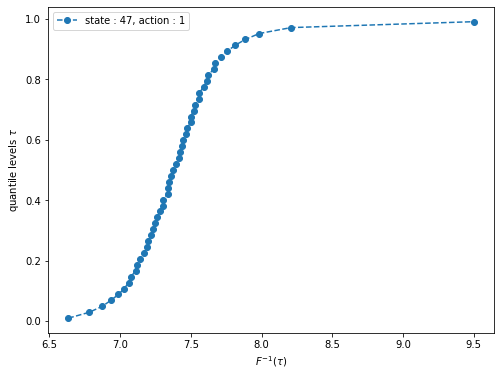

In [10]:
plot_theta(theta_1, 47, 1)

In [ ]:
tau = np.array(rl.horde.GVDs[0].z.tau)
theta_2 = rl.horde.horde_message("get theta values", 2)
q2 =  rl.horde.horde_message("get action values", 2)

In [46]:
save_theta('results/evaluation/gaussian/policy_4', GVD_2, exp_params, theta_2)

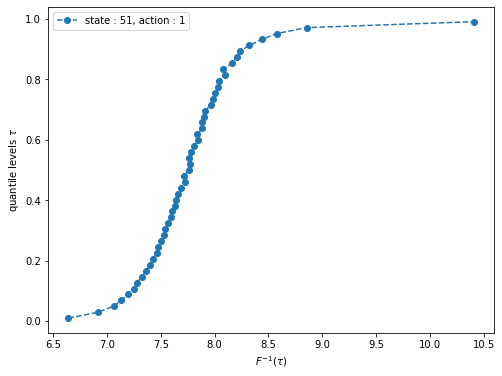

In [12]:
plot_theta(theta_1, 51, 1)

In [20]:
## state visitation

In [6]:
def run_experiment_with_state_visitation(filename, horde_info, env_info, exp_info):
    num_runs = exp_info['num_runs']
    num_episodes = exp_info['num_episodes']
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    all_state_visits = []
    run_steps_per_episode = np.zeros((num_runs, num_episodes))
    for run in tqdm(range(num_runs)):
        env = ToyEnvironment
        horde = SeparateHorde
        horde_info["seed"] = run
        random.seed(run)
        np.random.seed(run)
        tf.random.set_seed(run)
        agent_info = horde_info["GVDs_info"][0]
        rl_glue = RLGlueHorde(env, horde)
        rl_glue.rl_init(horde_info, env_info)
        state_visits = np.zeros(60)
        for episode in range(num_episodes):
            # Runs an episode while keeping track of visited states
            try :
                state, action = rl_glue.rl_start()
            except ValueError:
                with open("rl_debug", 'wb') as rl_debug:
                    pickle.dump(rl_glue, rl_debug)
            run_steps_per_episode[run, episode] += 1
            if episode >= num_episodes - 10:
                state_visits[state] += 1
            is_terminal = False
            while not is_terminal:
                try :
                    state, action, is_terminal = rl_glue.rl_step()
                    run_steps_per_episode[run, episode] += 1
                    if episode >= num_episodes - 10:
                        state_visits[state] += 1
                except ValueError:
                    with open("rl_debug", 'wb') as rl_debug:
                        pickle.dump(rl_glue, rl_debug)
        theta = rl_glue.horde.horde_message("get theta values", 1)
        all_state_visits.append(state_visits)
        save_theta(os.path.join(filename + current_time), agent_info, exp_info, theta)
    
    save_name = "runs_{}_episodes_{}".format(num_runs, num_episodes)
                
    if not os.path.exists(filename + current_time):
        os.makedirs(filename + current_time)
    np.save(os.path.join(filename + current_time, "all_state_visits_{}".format(save_name)), all_state_visits)
    np.save(os.path.join(filename + current_time, "run_steps_per_episode_{}".format(save_name)), run_steps_per_episode)

In [75]:
policy = np.ones(shape=(6 * 10, 4)) * 0.25
seed = 23
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
policy_4 = np.load("policy_4.npy")
policy_5 = np.load("policy_5.npy")
policy_6 = np.load("policy_6.npy")
file_path = 'results/monte_carlo/gaussian_policy5_returns_on_policy_ep_1000'

# average loss only
GVD_1 = {
    "control": True,
    "transition_gen" : gaussian_vs_gaussian,
    "num_quantiles" : 51,
    "beta" : -3,
    "replay_freq" : 5,
    "update_freq" : 500,
    "lr_scheduler" : True,
    "batch_size" : 32,
    "adam_epsilon" : 0.01/32,
    "eta" : 0.0005,
    "transition_gen_params" : {}}


horde_info = {
    "GVDs_info" : [GVD_1],
    "policy" : policy,
    "on_policy" : True,
    "on_policy_GVD" : 1,
    "epsilon_greedy" : True,
    "epsilon" : 1
}

env_info = {
    "end_states" : [[2,4], [4,6]]}

exp_info = {
    "num_episodes" : 500,
    "num_runs" : 10,
}

In [2]:
filename = 'results/control/gaussian_vs_gaussian/'

In [77]:
run_experiment_with_state_visitation(filename, horde_info, env_info, exp_info)


100%|██████████| 10/10 [18:14<00:00, 109.46s/it]


In [22]:
path = filename + '20200904-085634'

In [23]:
state_visits = np.load(os.path.join(path, 'all_state_visits_runs_10_episodes_500.npy'))
mean_visits = np.mean(state_visits, 0)

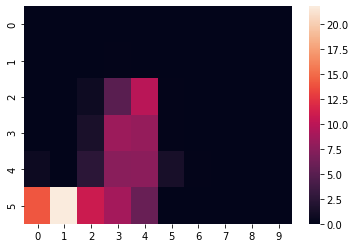

In [24]:
sns.heatmap(mean_visits.reshape(6,10))

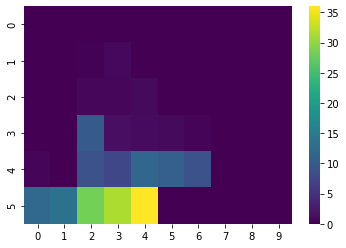

In [11]:
sns.heatmap(mean_visits.reshape(6,10), cmap = "viridis")
plt.savefig(path + '/state_visitation.png', dpi = 300)

In [25]:
run_steps = np.load(os.path.join(path, "run_steps_per_episode_runs_10_episodes_500.npy"))

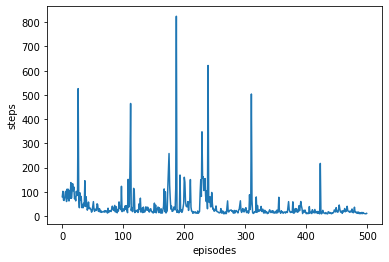

In [26]:
plt.plot(run_steps.mean(0))
plt.xlabel('episodes')
plt.ylabel('steps')
plt.savefig(path + '/run_steps.png', dpi = 300)